# PINNs-Based 1D Acoustic Wave Simulation with a Source Term

This notebook presents the numerical solution for the 1D elastic wave equation

The acoustic wave equation in 1D with constant density 

$$
\partial^2_t u(x,t) \ = \ c^2 \partial_x^2 u(x,t) + s(x,t)
$$

with pressure $p$, acoustic velocity $c$, and source term $s$.

In the following code block, we import the necessary libraries for our notebook. This includes NumPy for numerical operations, PyTorch for building and training the neural network, Matplotlib for plotting, a utility module for additional plotting functions, and the time module for timing our training process.

In [1]:
# Import NumPy for numerical operations
import numpy as np

# Import PyTorch for building and training neural networks
import torch
import torch.nn as nn
import torch.optim as optim

# Import Matplotlib for plotting
import matplotlib.pyplot as plt

# Import a utility module for additional plotting functions
import utils_plots

# Import the time module to time our training process
import time

# Import pickle for save and load the variables
import pickle

# Ignore Warning Messages
import warnings
warnings.filterwarnings("ignore")

In the following code block, we load the data obteined from a spectral elements implemented in the notebook W9_se_homo_1d_solution.ipynb with modified input parameters of the course [computers, waves, simulations](https://www.coursera.org/learn/computers-waves-simulations).

In [63]:
# Load the variables
with open('4_se_data.pkl', 'rb') as f:
    t_grid, x_grid, u_grid = pickle.load(f)
    
x_grid=np.array(x_grid)
t_grid=np.array(t_grid)
u_grid=np.array(u_grid)    


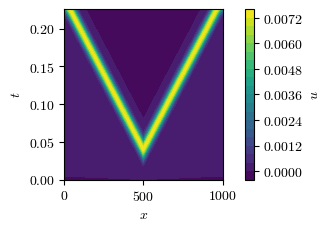

In [64]:
# Create a figure for the plot
# Set the figure size in inches
fig = plt.figure(figsize=(3.2, 2.2))

# Plot the u values as a function of t and x using a filled contour plot
# The 'levels' parameter determines the number and positions of the contour lines / regions
plt.contourf(x_grid, t_grid, u_grid, levels=20)

# Add a colorbar to the plot with the label 'u'
# The colorbar provides a visual guide to the range of values in the plot
plt.colorbar(label='$u$')

# Label the x and y axes
plt.xlabel('$x$')  # Label for the x-axis
plt.ylabel('$t$')  # Label for the y-axis

# Display the plot
plt.show()

In this simulation, we utilize a Gaussian function as the source term, which is typically characterized by its bell-shaped curve and defined by the following formula:

$$
s(x,t) = \text{{factor}} \cdot (t - t0) \cdot \exp(-a \cdot (t - t0)^2)
$$


In [251]:
# Define the factor for the source term
factor = 10e-3

dt = 0.01

nt = 100
nx = 100
# Create a time array from 0 to nt*dt with nt points
t = np.linspace(0 * dt, nt * dt, nt)

# Define the dominant frequency of the source (Hz)
f0 = 25.

# Calculate the source time shift
t0 = 1.0 / f0

# Calculate the constant 'a' for the Gaussian source term
a = np.pi*np.pi*f0*f0

# Calculate the src function
src = factor * 2 * (4 * f0) * np.exp(-1.0 * (4 * f0) ** 2 * (t - t0) ** 2)

# Normalize the src function
src_normalized =  src / np.max(src)

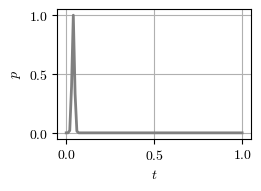

In [252]:
# Create a figure for the plot
fig, ax = plt.subplots(figsize=(2.5, 1.8))

# Plot the function
ax.plot(t,src_normalized, color='gray', linewidth=2)

# Set the labels for the x and y axes
ax.set_xlabel('$t$')
ax.set_ylabel('$p$')

# Display the grid
ax.grid(True)

# Display the plot
plt.show()

In [253]:
# Generate training data in NumPy
x_np = np.linspace(0, 1, 100)  # x data (numpy array), shape=(100,)
t_np = np.linspace(0, 1, 100)  # t data (numpy array), shape=(100,)

# Create a grid of x and t values
x_grid, t_grid = np.meshgrid(x_np, t_np) # x and t data (numpy array), shape=(100, 100)


# Convert x_grid, t_grid, and u_grid to PyTorch tensors
# The unsqueeze operation adds an extra dimension to the tensors
# The requires_grad_ method tells PyTorch that it will need to compute gradients with respect to these tensors
x_tensor = torch.from_numpy(x_grid).float().unsqueeze(-1).requires_grad_(True)
t_tensor = torch.from_numpy(t_grid).float().unsqueeze(-1).requires_grad_(True)
source_tensor = torch.from_numpy(src_normalized).float().unsqueeze(-1).requires_grad_(True)
#u_tensor = torch.from_numpy(u_grid).float().unsqueeze(-1)

# Combine x and t tensors to form the input data for the neural network
# The cat operation concatenates the tensors along the last dimension
input_data = torch.cat((x_tensor, t_tensor), dim=-1)

# Define the x and t boundaries of the problem domain
x_boundary = torch.linspace(0, np.max(x_grid), nx).view(-1, 1).requires_grad_(True)
t_boundary = torch.linspace(0, np.max(t_grid), nt).view(-1, 1).requires_grad_(True)

# Define the left and right boundaries
# For the left boundary, x is zero and t varies from 0 to max(t_grid)
# For the right boundary, x is max(x_grid) and t varies from 0 to max(t_grid)
x_left_boundary = torch.zeros_like(t_boundary)
t_left_boundary = t_boundary
x_right_boundary = np.max(x_grid) * torch.ones_like(t_boundary)
t_right_boundary = t_boundary

# Define the bottom and top boundaries
# For the bottom boundary, t is zero and x varies from 0 to max(x_grid)
# For the top boundary, t is max(t_grid) and x varies from 0 to max(x_grid)
x_bottom_boundary = x_boundary
t_bottom_boundary = torch.zeros_like(x_boundary)
x_top_boundary = x_boundary
t_top_boundary = np.max(t_grid) * torch.ones_like(x_boundary)


x_center_boundary =  np.max(x_grid)/2 * torch.ones_like(t_boundary)
t_center_boundary = t_boundary


# Combine the boundary tensors to form the input data for the boundary conditions
input_left_boundary = torch.cat((x_left_boundary, t_left_boundary), dim=-1)
input_bottom_boundary = torch.cat((x_bottom_boundary, t_bottom_boundary), dim=-1)
input_right_boundary = torch.cat((x_right_boundary, t_right_boundary), dim=-1)
input_top_boundary = torch.cat((x_top_boundary, t_top_boundary), dim=-1)
input_center_boundary = torch.cat((x_center_boundary, t_center_boundary), dim=-1)

In [243]:
input_center_boundary.shape

torch.Size([100, 2])

In [254]:
# Define a neural network class with three fully connected layers
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(2, 10)
        self.layer2 = nn.Linear(10, 10)
        self.output_layer = nn.Linear(10, 1)

    def forward(self, x):
        x = torch.tanh(self.layer1(x))
        x = torch.tanh(self.layer2(x))
        x = self.output_layer(x)
        return x
    
# Create an instance of the neural network
neural_net = NeuralNetwork()

# Define an optimizer (Adam) for training the network
optimizer = optim.Adam(neural_net.parameters(), lr=0.01)

# Define a loss function (Mean Squared Error) for training the network
loss_func = nn.MSELoss()

In [255]:
# Initialize a list to store the loss values
loss_values = []
c = 1 # wave speed

# Start the timer
start_time = time.time()

# Training the neural network
for i in range(1001):
    # Predictions for boundary conditions
    prediction_boundary_left = neural_net(input_left_boundary)
    prediction_boundary_bottom = neural_net(input_bottom_boundary)
    prediction_boundary_right = neural_net(input_right_boundary)
    prediction_boundary_top = neural_net(input_top_boundary)
    prediction_boundary_center = neural_net(input_center_boundary)

    # Compute boundary conditions
    boundary_left = prediction_boundary_left - 0
    boundary_bottom = prediction_boundary_bottom - 0
    boundary_right = prediction_boundary_right - 0
    boundary_top = prediction_boundary_top - 0
    boundary_center = prediction_boundary_center - source_tensor

    # Compute loss for boundary conditions
    loss_boundary_left = torch.mean(boundary_left**2)
    loss_boundary_bottom = torch.mean(boundary_bottom**2)
    loss_boundary_right = torch.mean(boundary_right**2)
    loss_boundary_top = torch.mean(boundary_top**2)
    loss_boundary_center = torch.mean(boundary_center**2)
    
    loss_boundary = loss_boundary_left + loss_boundary_bottom + loss_boundary_right + loss_boundary_top + 2*loss_boundary_center
   
    # Predictions for physics conditions
    prediction = neural_net(input_data)

    # Compute derivatives of prediction with respect to x_tensor and t_tensor
    dudx  = torch.autograd.grad(prediction, x_tensor, torch.ones_like(prediction), create_graph=True)[0] # computes du/dx
    dudx2 = torch.autograd.grad(dudx,  x_tensor, torch.ones_like(dudx),  create_graph=True)[0] # computes d^2u/dx^2
    dudt  = torch.autograd.grad(prediction, t_tensor, torch.ones_like(prediction), create_graph=True)[0] # computes du/dt
    dudt2 = torch.autograd.grad(dudt,  t_tensor, torch.ones_like(dudt),  create_graph=True)[0] # computes d^2u/dt^2

    # Compute physics condition
    physics = dudt2 - c**2*dudx2  

    # Compute loss for physics condition
    loss_physics = torch.mean(physics**2)

    # Total loss is the sum of boundary and physics loss
    loss = loss_boundary + loss_physics

    # Append the current loss value to the list
    loss_values.append(loss.item())

    # Clear gradients for next train
    optimizer.zero_grad()

    # Backpropagation, compute gradients
    loss.backward()

    # Update weights
    optimizer.step()

    # Print loss every 100 iterations
    if i % 100 == 0:
        print(f"Iteration {i}: Loss {loss.item()}")

# Stop the timer and calculate the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time

# Print training time
print(f"Training time: {elapsed_time} seconds")

# Save a summary of the training process to a text file
with open("summaries/4_1D_Acoustic_Wave_Simulation_PINNs.txt", "w") as file:
    file.write("Summary of Neural Network Training\n")
    file.write("=================================\n\n")
    file.write(f"Neural Network Architecture:\n{neural_net}\n\n")
    file.write(f"Optimizer Used:\n{type(optimizer).__name__}\n\n")
    file.write(f"Learning Rate:\n{optimizer.param_groups[0]['lr']}\n\n")
    file.write(f"Number of Iterations:\n{len(loss_values)}\n\n")
    file.write(f"Initial Loss:\n{loss_values[0]}\n\n")
    file.write(f"Final Loss:\n{loss_values[-1]}\n\n")
    file.write(f"Training Time:\n{elapsed_time} seconds\n\n")
    
    # Calculate the average loss
    average_loss = sum(loss_values) / len(loss_values)
    file.write(f"Average Loss:\n{average_loss}\n\n")
    
    # Find the iteration with the minimum loss
    min_loss_value = min(loss_values)
    min_loss_iteration = loss_values.index(min_loss_value)
    file.write(f"Minimum Loss:\n{min_loss_value} at iteration {min_loss_iteration}\n\n")

Iteration 0: Loss 0.06398394703865051


Iteration 100: Loss 0.024793224409222603
Iteration 200: Loss 0.02477819286286831
Iteration 300: Loss 0.024768367409706116
Iteration 400: Loss 0.024760328233242035
Iteration 500: Loss 0.024753089994192123
Iteration 600: Loss 0.02474546805024147
Iteration 700: Loss 0.024736221879720688
Iteration 800: Loss 0.02472410351037979
Iteration 900: Loss 0.024707378819584846
Iteration 1000: Loss 0.024682367220520973
Training time: 16.655739784240723 seconds


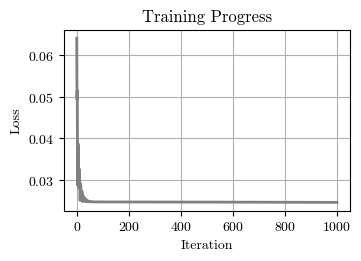

In [256]:
# Create a figure for the plot
fig = plt.figure(figsize=(3.5, 2.5))

# Plot the loss values recorded during training
plt.plot(loss_values, color='gray', linewidth=2)

# Set the labels for the x and y axes
plt.xlabel('Iteration')
plt.ylabel('Loss')

# Set the title for the plot
plt.title('Training Progress')

# Display the grid
plt.grid(True)

# Save the plot as a PNG file in the 'imgs' directory
fig.savefig('imgs/4_1D_Acoustic_Wave_Simulation_PINNs.png', format='png')

# Display the plot
plt.show()

In [257]:
# Save the trained model's parameters to a file
torch.save(neural_net.state_dict(), 'models/4_1D_Acoustic_Wave_Simulation_PINNs.pth')

# Initialize a new instance of the neural network
new_neural_net = NeuralNetwork()

# Load the saved parameters into the new instance of the neural network
new_neural_net.load_state_dict(torch.load('models/4_1D_Acoustic_Wave_Simulation_PINNs.pth'))

# Ensure the new neural network is in evaluation mode
new_neural_net.eval()

NeuralNetwork(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (output_layer): Linear(in_features=10, out_features=1, bias=True)
)

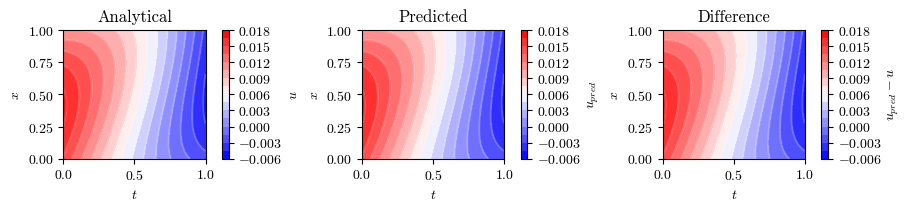

In [258]:
# Generate predictions using the neural network and reshape to match grid
u_pred = neural_net(input_data).detach().numpy().reshape(x_grid.shape)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 3, figsize=(9, 2))

# Define a function to plot a contour graph
def plot_contour(ax, x, y, z, title, label):
    im = ax.contourf(x, y, z, origin='lower', levels=20, cmap=utils_plots.cmap_)
    ax.set_title(title)
    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    fig.colorbar(im, ax=ax, label=label)
    ax.contour(x, y, z, levels=20, colors='white', alpha=0.2, linestyles='solid')

# Plot the predicted u values
plot_contour(axs[0], t_grid, x_grid, u_pred, 'Analytical', '$u$')

# Plot the predicted u values
plot_contour(axs[1], t_grid, x_grid, u_pred, 'Predicted', '$u_{pred}$')

# Plot the difference between the predicted and analytical u values
plot_contour(axs[2], t_grid, x_grid, u_pred, 'Difference', '$u_{pred}-u$')

# Save the plot as a PDF file in the 'imgs' directory
fig.savefig('imgs/3_Predicted_and_Difference_Approximation_with_PINNs.png', format='png')

# Display the plot
plt.show()